In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input , Dense, Lambda, Normalization, Concatenate
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, schedules
from tensorflow_addons.optimizers import AdamW, extend_with_decoupled_weight_decay

from tensorflow.keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard, \
                                        EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

import numpy as np
import random
import os

import gc

from tqdm import tqdm 

/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220427). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [5]:
import import_ipynb

from modules import convkxf, GroupGRULayer, GroupFC
from loss import MaskLoss, LocalSnrTarget, DfAlphaLoss, SpectralLoss, SISNR_Loss
from utils import mask_operations, df_operations, synthesis_frame, df_operations_wo_alpha
from params import model_params
from dataloader import read_tfrecod_data
from bandERB import ERBBand, ERB_pro_matrix

importing Jupyter notebook from modules.ipynb
importing Jupyter notebook from loss.ipynb
importing Jupyter notebook from bandERB.ipynb
importing Jupyter notebook from params.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from dataloader.ipynb


In [6]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession, enable_eager_execution

config = ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
InteractiveSession(config=config)
enable_eager_execution(config=config)

# tf.compat.v1.disable_eager_execution()

# Read config

In [7]:
p = model_params('config.ini')

In [8]:
def as_complex(x):
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        return x
    else:
        return np.complex(x[...,-2], x[..., -1])

def as_real(x):
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        return np.concatenate([np.expand_dims(np.real(x),axis=-1), 
                               np.expand_dims(np.imag(x),axis=-1)],axis=-1)
    else: return x

# Model construction

In [9]:
erb_inputs = Input(shape=(None, p.nb_erb, 1), batch_size=1, name='ERB_input')
spec_inputs = Input(shape=(None, p.nb_df, 2), batch_size=1, name='spec_input') # complex
clean_spec = Input(shape=(None, p.fft_size//2+1, 2), batch_size=1, name='clean_spec') # complex
noisy_spec = Input(shape=(None, p.fft_size//2+1, 2), batch_size=1, name='noisy_spec') # complex

In [10]:
erb_conv0 = convkxf(erb_inputs, p.conv_out_ch, k=3, f=3, fstride=1, bias=False, training=False, name='conv0_encoder')
erb_conv1 = convkxf(erb_conv0, p.conv_out_ch, k=1, f=3, fstride=2, bias=False, name='conv1_encoder')
erb_conv2 = convkxf(erb_conv1, p.conv_out_ch, k=1, f=3, fstride=2, bias=False, name='conv2_encoder')
erb_conv3 = convkxf(erb_conv2, p.conv_out_ch, k=1, f=3, fstride=1, bias=False, name='conv3_encoder')

if not p.mask_only: 
    df_conv0 = convkxf(spec_inputs, p.conv_out_ch, k=3, f=3, fstride=1, training=False, name='df_conv0_encoder')
    df_conv1 = convkxf(df_conv0, p.conv_out_ch, k=1, f=3, fstride=2, name='df_conv1_encoder')
    
#     shape = df_conv1.get_shape().as_list()
    shape = [tf.shape(df_conv1)[k] for k in range(4)]
    df_conv1 = tf.transpose(df_conv1,(0,1,3,2))
    df_conv1 = tf.reshape(df_conv1, [shape[0], shape[1], shape[2]*shape[3]])
    
    cemb = GroupFC(df_conv1, p.fc_hidden, p.fc_group, name='GFC_encoder')
    
#shape = erb_conv3.get_shape().as_list()    
shape = [tf.shape(erb_conv3)[k] for k in range(4)]
if p.mask_only: 
    emb = tf.reshape(tf.transpose(erb_conv3,(0,1,3,2)), [shape[0], shape[1], shape[2]*shape[3]])
else:           
    emb = Concatenate()([cemb, tf.reshape(tf.transpose(erb_conv3,(0,1,3,2)), [-1, shape[1], shape[2]*shape[3]])])

GRU_emb = GroupGRULayer(emb, p.gru_hidden, p.gru_group, num_layer=1, name='GGRU0', add_output=True, training=False)

In [11]:
GRU_emb2 = GroupGRULayer(GRU_emb, p.gru_hidden, p.gru_group, num_layer=2, name='GGRU01', add_output=True, training=False)
de_emb = GroupFC(GRU_emb2, p.fc_hidden, p.fc_group, activation='relu', name='GFC_decoder')

shape = [tf.shape(erb_conv3)[k] for k in range(4)]
# shape = erb_conv3.get_shape().as_list()
emb_decoder = tf.reshape(de_emb, shape = [shape[0], shape[1], shape[2], shape[3]], name='decoder_reshape')

kwargs = {
    "k": 1,
    "batch_norm": True,
}
tkwargs = {
    "k": 1,
    "batch_norm": True,
    "mode": "transposed"
}
pkwargs = {
    "k": 1,
    "f": 1,
    "batch_norm": True,
}

convp3 = convkxf(erb_conv3, out_ch=p.conv_out_ch, name='convp3', **pkwargs)  # Conv
vt3_in = convp3 + emb_decoder
convt3 = convkxf(vt3_in, out_ch=p.conv_out_ch, fstride=1, name='convt3', **kwargs) #ConvT

convp2 = convkxf(erb_conv2, out_ch=p.conv_out_ch, name='convp2', **pkwargs) # Conv
vt2_in = convp2 + convt3
convt2 = convkxf(vt2_in, out_ch=p.conv_out_ch, name='convt2', **tkwargs)

convp1 = convkxf(erb_conv1, out_ch=p.conv_out_ch, name='convp1', **pkwargs) # Conv
vt1_in = convp1 + convt2
convt1 = convkxf(vt1_in, out_ch=p.conv_out_ch, name='convt1', **tkwargs)

convp0 = convkxf(erb_conv0, out_ch=p.conv_out_ch, training=True, name='convp0', **pkwargs) # Conv
vt0_in = convp0 + convt1
mask_out = convkxf(vt0_in, out_ch=1, k=1, fstride=1, act='sigmoid', training=True, reshape=True, name='mask_out')

In [12]:
if not p.mask_only:
    GRU_emb2 = GroupGRULayer(GRU_emb, p.gru_hidden, p.gru_group, num_layer=2, name='GGRU1', add_output=True, training=False)

    convp = convkxf(df_conv0, 2*p.df_order, k=1, f=1, complex_in=True, batch_norm=True, name='convp_DfDecoder') 
    convp = tf.transpose(convp, (0,1,3,2))

    df_alpha = sigmoid(Dense(1, name='convp_alpha')(GRU_emb2))
    c = tanh(Dense(p.nb_df*p.df_order*2, name='convp_c')(GRU_emb2))

    shape = [tf.shape(c)[k] for k in range(2)]
#     shape = c.get_shape().as_list()
    c = tf.reshape(c,(shape[0], shape[1], p.df_order*2, p.nb_df))
        
    c = tf.reshape(c + convp,(shape[0], shape[1], p.df_order, 2, p.nb_df))

    df_coeff = tf.transpose(c, [0, 1, 2, 4, 3], name='output_c')

# Enhance operation

In [13]:
spec = mask_operations(noisy_spec, mask_out) # mask gain
enhanced = df_operations(spec, df_coeff, df_alpha) # deep filter

# Loss

In [16]:
maskloss = Lambda(lambda x:MaskLoss(*x, factor=p.mask_factor, r=p.mask_gamma), name='maskloss')([mask_out, clean_spec, noisy_spec])

In [17]:
lsnr_min, lsnr_max = -15, 35
lsnr = LocalSnrTarget(ws=20, target_snr_range=[lsnr_min - 5, lsnr_max + 5])
lsnr_gt = lsnr.forward(clean_spec, noise= noisy_spec - clean_spec, max_bin=p.nb_df)

In [18]:
# if not p.mask_only: 
#     dfalphaloss = Lambda(lambda x:DfAlphaLoss(*x, factor=p.alpha_factor), name='dfalphaloss')([df_alpha, lsnr_gt])
spectralloss = Lambda(lambda x:SpectralLoss(*x, gamma=p.df_gamma, factor_mag=p.df_factor, factor_img=p.df_factor), name='spectralloss')([enhanced, clean_spec])

# Model compile

In [20]:
if p.mask_only: 
    if p.sisnr:
        inputs = [erb_inputs, clean_spec, noisy_spec]
        outputs = [sisnr, maskloss]
    else:
        inputs = [erb_inputs, clean_spec, noisy_spec]
        outputs = [spectralloss, maskloss]
else:
    if p.sisnr: 
        inputs = [erb_inputs, spec_inputs, clean_spec, noisy_spec]
        outputs = [sisnr, maskloss, spectralloss]
#         outputs = [sisnr, maskloss, dfalphaloss, spectralloss]
    else:
        inputs = [erb_inputs, spec_inputs, clean_spec, noisy_spec]
        outputs = [maskloss, spectralloss]
#         outputs = [maskloss, dfalphaloss, spectralloss]

In [21]:
model=Model(inputs=inputs, outputs=outputs, name='DfNet')

In [22]:
model.summary()

Model: "DfNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ERB_input (InputLayer)         [(1, None, 32, 1)]   0           []                               
                                                                                                  
 tf.compat.v1.pad (TFOpLambda)  (1, None, 34, 1)     0           ['ERB_input[0][0]']              
                                                                                                  
 spec_input (InputLayer)        [(1, None, 96, 2)]   0           []                               
                                                                                                  
 conv0_encoder (Conv2D)         (1, None, 32, 64)    576         ['tf.compat.v1.pad[0][0]']       
                                                                                              

 mbda)                                                                                            
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  ()                  0           ['tf.compat.v1.shape_1[0][0]']   
 icingOpLambda)                                                                                   
                                                                                                  
 tf.math.multiply (TFOpLambda)  ()                   0           ['tf.__operators__.getitem_2[0][0
                                                                 ]',                              
          

 tf.compat.v1.shape_5 (TFOpLamb  (4,)                0           ['tf.compat.v1.transpose_1[0][0]'
 da)                                                             ]                                
                                                                                                  
 tf.__operators__.getitem_7 (Sl  ()                  0           ['tf.compat.v1.shape_7[0][0]']   
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_6 (Sl  ()                  0           ['tf.compat.v1.shape_6[0][0]']   
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.shape_9 (TFOpLamb  (4,)                0           ['tf.where_3[0][0]']             
 da)      

 licingOpLambda)                                                                                  
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  ()                  0           ['tf.__operators__.getitem_15[0][
 )                                                               0]',                             
                                                                  'tf.__operators__.getitem_14[0][
                                                                 0]']                             
                                                                                                  
 tf.reshape_3 (TFOpLambda)      (1, None, 256)       0           ['tf.stack_1[0][0]',             
                                                                  'tf.__operators__.getitem_12[0][
                                                                 0]',                             
          

 tf.__operators__.getitem_20 (S  ()                  0           ['tf.compat.v1.shape_20[0][0]']  
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_21 (S  ()                  0           ['tf.compat.v1.shape_21[0][0]']  
 licingOpLambda)                                                                                  
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  ()                  0           ['tf.__operators__.getitem_23[0][
 )                                                               0]',                             
                                                                  'tf.__operators__.getitem_22[0][
                                                                 0]']                             
          

                                                                                                  
 tf.math.multiply_6 (TFOpLambda  ()                  0           ['tf.__operators__.getitem_27[0][
 )                                                               0]',                             
                                                                  'tf.__operators__.getitem_26[0][
                                                                 0]']                             
                                                                                                  
 convp3_1x1 (Conv2D)            (1, None, 8, 64)     4096        ['convp3[0][0]']                 
                                                                                                  
 tf.reshape_6 (TFOpLambda)      (1, None, 512)       0           ['tf.compat.v1.transpose_4[0][0]'
                                                                 , 'tf.__operators__.getitem_24[0]
          

                                                                                                  
 tf.math.less_8 (TFOpLambda)    (1, None, 8, 64)     0           ['batch_normalization_1[0][0]']  
                                                                                                  
 tf.where_9 (TFOpLambda)        (1, None, 8, 64)     0           ['tf.math.less_9[0][0]',         
                                                                  'batch_normalization_2[0][0]']  
                                                                                                  
 tf.where_8 (TFOpLambda)        (1, None, 8, 64)     0           ['tf.math.less_8[0][0]',         
                                                                  'batch_normalization_1[0][0]']  
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (1, None, 8, 64)    0           ['tf.where_9[0][0]',             
 mbda)    

 conv2d_transpose_2 (Conv2DTran  (1, None, 16, 1)    4           ['tf.split_5[0][2]']             
 spose)                                                                                           
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (1, None, 16, 1)    4           ['tf.split_5[0][3]']             
 spose)                                                                                           
                                                                                                  
 conv2d_transpose_4 (Conv2DTran  (1, None, 16, 1)    4           ['tf.split_5[0][4]']             
 spose)                                                                                           
                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (1, None, 16, 1)    4           ['tf.split_5[0][5]']             
 spose)   

                                                                                                  
 conv2d_transpose_30 (Conv2DTra  (1, None, 16, 1)    4           ['tf.split_5[0][30]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_31 (Conv2DTra  (1, None, 16, 1)    4           ['tf.split_5[0][31]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_32 (Conv2DTra  (1, None, 16, 1)    4           ['tf.split_5[0][32]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_tr

 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_58 (Conv2DTra  (1, None, 16, 1)    4           ['tf.split_5[0][58]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_59 (Conv2DTra  (1, None, 16, 1)    4           ['tf.split_5[0][59]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_60 (Conv2DTra  (1, None, 16, 1)    4           ['tf.split_5[0][60]']            
 nspose)                                                                                          
          

                                                                  'conv2d_transpose_61[0][0]',    
                                                                  'conv2d_transpose_62[0][0]',    
                                                                  'conv2d_transpose_63[0][0]']    
                                                                                                  
 convp1_1x1 (Conv2D)            (1, None, 16, 64)    4096        ['convp1[0][0]']                 
                                                                                                  
 convt2_1x1 (Conv2D)            (1, None, 16, 64)    4096        ['tf.concat[0][0]']              
                                                                                                  
 batch_normalization_4 (BatchNo  (1, None, 16, 64)   256         ['convp1_1x1[0][0]']             
 rmalization)                                                                                     
          

                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
                                 (1, None, 16, 1),                                                
          

                                                                                                  
 conv2d_transpose_87 (Conv2DTra  (1, None, 32, 1)    4           ['tf.split_6[0][23]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_88 (Conv2DTra  (1, None, 32, 1)    4           ['tf.split_6[0][24]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_transpose_89 (Conv2DTra  (1, None, 32, 1)    4           ['tf.split_6[0][25]']            
 nspose)                                                                                          
                                                                                                  
 conv2d_tr

 anspose)                                                                                         
                                                                                                  
 conv2d_transpose_115 (Conv2DTr  (1, None, 32, 1)    4           ['tf.split_6[0][51]']            
 anspose)                                                                                         
                                                                                                  
 conv2d_transpose_116 (Conv2DTr  (1, None, 32, 1)    4           ['tf.split_6[0][52]']            
 anspose)                                                                                         
                                                                                                  
 conv2d_transpose_117 (Conv2DTr  (1, None, 32, 1)    4           ['tf.split_6[0][53]']            
 anspose)                                                                                         
          

                                                                  'conv2d_transpose_101[0][0]',   
                                                                  'conv2d_transpose_102[0][0]',   
                                                                  'conv2d_transpose_103[0][0]',   
                                                                  'conv2d_transpose_104[0][0]',   
                                                                  'conv2d_transpose_105[0][0]',   
                                                                  'conv2d_transpose_106[0][0]',   
                                                                  'conv2d_transpose_107[0][0]',   
                                                                  'conv2d_transpose_108[0][0]',   
                                                                  'conv2d_transpose_109[0][0]',   
                                                                  'conv2d_transpose_110[0][0]',   
          

                                                                                                  
 tf.split_8 (TFOpLambda)        [(1, None, 256)]     0           ['tf.reshape_8[0][0]']           
                                                                                                  
 tf.__operators__.add_4 (TFOpLa  (1, None, 32, 64)   0           ['tf.where_13[0][0]',            
 mbda)                                                            'tf.where_12[0][0]']            
                                                                                                  
 GGRU11_0 (GRU)                 (1, None, 256)       394752      ['tf.split_8[0][0]']             
                                                                                                  
 tf.compat.v1.pad_7 (TFOpLambda  (1, None, 34, 64)   0           ['tf.__operators__.add_4[0][0]'] 
 )                                                                                                
          

 tf.compat.v1.shape_40 (TFOpLam  (3,)                0           ['tf.math.tanh[0][0]']           
 bda)                                                                                             
                                                                                                  
 tf.compat.v1.shape_41 (TFOpLam  (3,)                0           ['tf.math.tanh[0][0]']           
 bda)                                                                                             
                                                                                                  
 tf.math.less_14 (TFOpLambda)   (1, None, 96, 10)    0           ['batch_normalization_7[0][0]']  
                                                                                                  
 tf.split_9 (TFOpLambda)        [(1, None, 96, 1),   0           ['tf.compat.v1.pad_8[0][0]']     
                                 (1, None, 96, 1)]                                                
          

                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (1, None, 5, 96)    0           ['tf.__operators__.getitem_43[0][
 a)                                                              0]',                             
                                                                  'tf.__operators__.getitem_44[0][
                                                                 0]']                             
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (1, None, 5, 96)    0           ['tf.__operators__.getitem_45[0][
 a)                                                              0]',                             
                                                                  'tf.__operators__.getitem_46[0][
                                                                 0]']                             
          

In [24]:
if p.mask_only:
    LOSS = spectralloss
    model.add_metric(maskloss, name = "maskloss")
    model.add_metric(spectralloss, name = "spectralloss")
else:
    LOSS = spectralloss
    model.add_metric(maskloss, name = "maskloss")
#     model.add_metric(dfalphaloss, name = "dfalphaloss")
    model.add_metric(spectralloss, name = "spectralloss")
model.add_loss(LOSS)

In [25]:
optimizer = AdamW(learning_rate=p.lr, weight_decay=0.0)#, clipnorm=1)

In [26]:
model.compile(optimizer=optimizer, run_eagerly=True) #, loss_weights={"dfalphaloss": 1, "spectralloss": 20}) 

# Pre-train weight

In [27]:
h5_lists = os.listdir("./weights2_1/")
h5_lists.sort(key=lambda fn:os.path.getmtime("./weights2_1/" + fn)
                if not os.path.isdir("./weights2_1/" + fn) else 0)
new_file = os.path.join("./weights2_1/", h5_lists[-1])
print(new_file)

model.load_weights(new_file)

./weights2_1/weights.07-56.01.h5


# Load

In [28]:
if p.mask_only: 
    inputs = [erb_inputs, spec_inputs]
    outputs = [mask_out]
else: 
    inputs = [erb_inputs, spec_inputs]
    outputs = [mask_out, df_alpha, df_coeff]

model = Model(inputs=inputs, outputs=outputs, name='DfNet')

# Norm

In [30]:
def band_unit_norm(x, s, alpha=0.99):
    s = np.linalg.norm(x) * (1-alpha) + s * alpha
    x = x / (np.sqrt(s)+1e-12)
    return x, s
def band_mean_norm_erb(x, s, alpha=0.99):
    s = x * (1-alpha) + s * alpha
    x = (x-s) / 40
    return x, s

def erb_norm(x, mean_init=[-60.0,-90.0]):
    # x : [T,F,C]
    # state: [F,C]
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    shape = x.shape
    state = np.linspace(mean_init[0],mean_init[1],shape[-2]) # [F,]
    state *= 0
    state = np.reshape(state, (1, shape[-2]))
    state = np.tile(state, (1, shape[-1])) # [C,F]
    
    x_i_list = []
    state_list = []
    
    for i in range(shape[-1]):
        x_i = np.split(x, shape[-1], axis=-1) 
        state_i = np.split(state, shape[-1], axis=-1)
        
        x_ij_list = []
        state_tmp = state_i[i]
        for j in range(shape[-3]):
            x_ij = np.split(x_i[i], shape[0], axis=0) 
            x_tmp, state_tmp = band_mean_norm_erb(np.squeeze(x_ij[j],-1), state_tmp)
            x_ij_list.append(x_tmp)
        
        x_i_list.append(np.stack(x_ij_list,1))
        state_list.append(state_tmp)
    x = np.squeeze(np.stack(x_i_list,-1),0)
    return x

def unit_norm(x, unit_init=[0.001, 0.0001]):
    # x : [T,F,C]
    # state: [F,C]
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    shape = x.shape
    state = np.linspace(unit_init[0],unit_init[1],shape[-2]) # [F,]
    state *= 0
    state = np.reshape(state, (1, shape[-2]))
    state = np.tile(state, (1, shape[-1])) # [C,F]
    
    x_i_list = []
    state_list = []
    
    for i in range(shape[-1]):
        x_i = np.split(x, shape[-1], axis=-1) 
        state_i = np.split(state, shape[-1], axis=-1)
        
        x_ij_list = []
        state_tmp = state_i[i]
        for j in range(shape[-3]):
            x_ij = np.split(x_i[i], shape[0], axis=0) 
            x_tmp, state_tmp = band_unit_norm(np.squeeze(x_ij[j],-1), state_tmp)
            x_ij_list.append(x_tmp)
        
        x_i_list.append(np.stack(x_ij_list,1))
        state_list.append(state_tmp)
    
    x = np.squeeze(np.stack(x_i_list,-1))
#     print('done spec')
    return x

In [31]:
ERBB = ERBBand(N=p.nb_erb, high_lim=p.sr//2, NFFT=p.fft_size)
ERB_Matrix = ERB_pro_matrix(ERBB, NFFT=p.fft_size, mode=0)
iERB_Matrix = ERB_pro_matrix(ERBB, NFFT=p.fft_size, mode=1)

In [32]:
import librosa
from soundfile import write
import matplotlib.pyplot as plt

In [33]:
# import tensorflow as tf
def vorbis_window(FRAME_SIZE, transpose=True):
    FRAME_SIZE = FRAME_SIZE//2
    win = np.zeros((FRAME_SIZE,))
    for i in range(FRAME_SIZE):
        win[i] = np.sin(.5*np.pi*np.sin(.5*np.pi*(i+.5)/FRAME_SIZE) * np.sin(.5*np.pi*(i+.5)/FRAME_SIZE))

    win = np.concatenate((win,np.flip(win)),0)
    if transpose: win = win.T
    return win

def analysis_frame(x, nfft=p.fft_size, hop=p.hop_size, normalize=False):
    length = len(x)
    n_frames = length // hop
    out = np.empty((n_frames, p.fft_size//2+1),dtype=complex)
    if not length % hop == 0:
        x = np.pad(x,(0, nfft - length%hop))
    for frame_idx in range(0, n_frames * hop, hop):
        frame = x[frame_idx : frame_idx + nfft]
        if len(frame)<nfft: frame = np.pad(frame,(0,nfft-len(frame)))
        win = vorbis_window(nfft)
        frame = frame.reshape(win.shape)
        frame_win = np.multiply(frame, win)
        x_fft = np.fft.rfft(frame_win, n=p.fft_size) 
        if normalize: x_fft *= (p.fft_size ** -0.5)
        out[frame_idx//hop,:] = x_fft
    return out 

def synthesis_frame(x, nfft=p.fft_size, hop=p.hop_size, windowing=False, normalize=False):
    n_frames, _ = x.shape
    length = (n_frames+1)*hop
    out = np.zeros((length,))

    win = vorbis_window(nfft, transpose=False)
    if normalize: x /= (p.fft_size ** -0.5)
    for frame_idx in range(0, n_frames * hop, hop):
        frame = np.fft.irfft(x[frame_idx//hop] , n=p.fft_size)
        
        if windowing:
            frame = frame.reshape(win.shape)
            out[frame_idx : frame_idx + nfft] += np.multiply(frame, win)
        else:
            out[frame_idx : frame_idx + nfft] += frame
    return out

In [34]:
process_path = '/home/myhsueh/DeepFilterNet/wav/proc/'
audiofile = [ 
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample3_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample1_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample2_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample6_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample7_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample9_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample11_01.wav',
              
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_usbmicrophone_APPND34J4EDS3_typing_near_fileid_5.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_speaker_A33BAVCUPSMTWJ_Typing_near_fileid_11.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_ASEW6NZHLI41K_typing_far_fileid_9.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_ASEW6NZHLI41K_openingchipspacket_near_fileid_1.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_dogbarking_near_fileid_si2192.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_babycrying_far_fileid_si1687.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_ArConditioner_near_fileid_si2313.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_laptopmic_A9AP3ED0K8LS8_heavybreathing_near_fileid_6.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_emotional_Desktopstandmic_AHLK9SWDJHBBZ_clatternoise_near_crying_fileid_8.wav',
    
              '/home/myhsueh/DeepFilterNet/wav/orig/conference_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/02-V4K-220511_record.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/enc_01.wav',
            ]

In [51]:
def process(audiofile, process_path='/home/myhsueh/DeepFilterNet/wav/proc/dfn2/'):
    y, sr = librosa.load(audiofile, sr=None)
    
    new_filename = os.path.basename(audiofile)
#     new_filename = new_filename.replace('ms_realrec_','DNStest_')
    new_filename = new_filename.replace('.wav','dfn'+str(buffer_frame)+'.wav')
#     new_filename = new_filename.replace('_01','')
#     new_filename = new_filename.replace('record','record_dfn')
    
    Y = analysis_frame(y, normalize=True)
    
    Y_erb = (np.real(Y)**2 + np.imag(Y)**2) @ ERB_Matrix
    Y_erb_norm = erb_norm(np.sqrt(Y_erb))
    Y_spec_norm = as_real(unit_norm(Y[:,:p.nb_df]))
                            
    buffer = np.zeros((buffer_frame,p.fft_size//2+1), dtype=complex)
    buffer_erb = np.zeros((buffer_frame+2,32,1))
    buffer_spec = np.zeros((buffer_frame+2,96,2))
    Z = np.zeros_like(Y, dtype=complex)
    
    for i in range(Y.shape[0]-1):
        buffer = np.roll(buffer, -1, axis=0)
        buffer[-1] = Y[i]
        if buffer_frame==1:
            buffer[0] = Y[i]
        
        buffer_erb = np.roll(buffer_erb, -1, axis=0)
        buffer_erb[-1] = Y_erb_norm[i]
        
        buffer_spec = np.roll(buffer_spec, -1, axis=0)
        buffer_spec[-1] = Y_spec_norm[i]

                
        if p.mask_only:
            mask_out = model.predict(np.expand_dims(buffer_erb,0), verbose=0)
            buffer_real = np.concatenate((np.expand_dims(np.real(buffer),-1),np.expand_dims(np.imag(buffer),-1)),axis=-1)
            enhanced = mask_operations(buffer_real, mask_out, training=False) # mask gain
        else:
            buffer_feature = [np.expand_dims(np.expand_dims(buffer_erb,-1),0), np.expand_dims(buffer_spec,0)]
            mask_out, df_alpha, df_coeff = model.predict(buffer_feature, verbose=0)
#             print(mask_out.shape)
            buffer_real = np.concatenate((np.expand_dims(np.real(buffer),-1),np.expand_dims(np.imag(buffer),-1)),axis=-1)
            buffer_spec_proc = mask_operations(buffer_real, mask_out, training=False) # mask gain
#             df_alpha = tf.cast(df_alpha,tf.float64)
            enhanced = df_operations(buffer_spec_proc, df_coeff, df_alpha) # deep filter
        enhanced = np.squeeze(enhanced)
        enhanced_complex = np.squeeze(enhanced[..., 0]+1j*enhanced[..., 1])
        
        if buffer_frame==1:
            Z[i,:] = enhanced_complex
        else:
#             Z[i-1:i+1,:] = enhanced_complex[-3:-1]  # Add for cross
            Z[i,:] = enhanced_complex[-1]
    
    model.reset_states()   
    
    z = synthesis_frame(Z, windowing=True, normalize=True)
    if not os.path.exists(process_path): os.makedirs(process_path)
    y = np.reshape(y,(y.shape[0],1))
    z = np.reshape(z,(z.shape[0],1))
    if y.shape[0]>z.shape[0]:
        z = np.concatenate((np.zeros((y.shape[0]-z.shape[0],1)),z),axis=0)
    if y.shape[0]<z.shape[0]:
        y = np.concatenate((np.zeros((z.shape[0]-y.shape[0],1)),y),axis=0)
    write(os.path.join(process_path,new_filename), np.concatenate((y,z),axis=1), 48000)
    
    plt.figure(figsize=(10,5))
    plt.plot(y, color = 'b')
    plt.plot(z, color = 'r')
    plt.legend(['unproc','proc'])
    plt.show()
    
    return Y.shape[0]

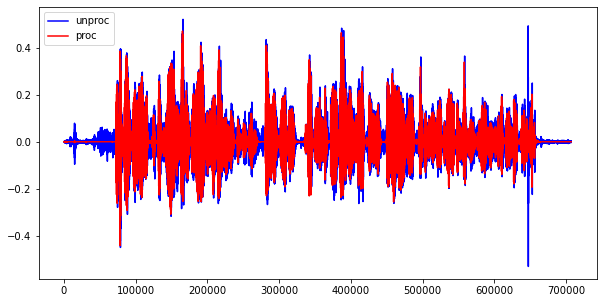

0.04905105803323829


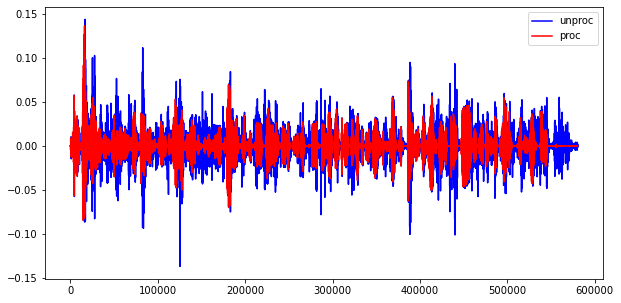

0.048392435770161106


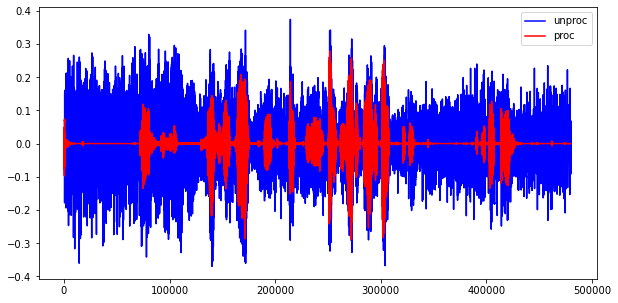

0.045644110918045044


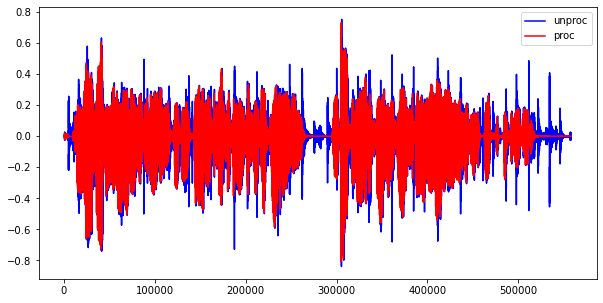

0.0459414014717798


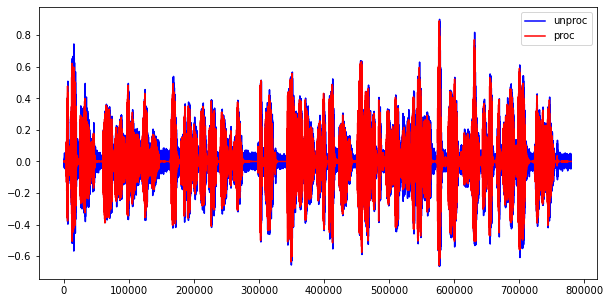

0.04694335830622706


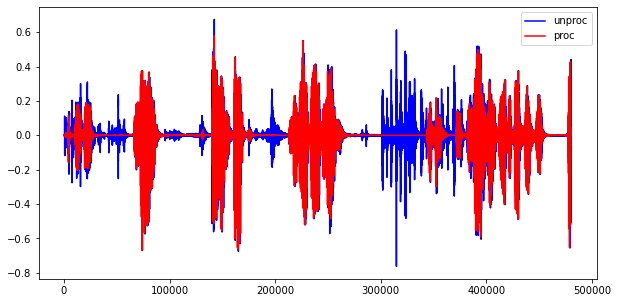

0.04502937507629395


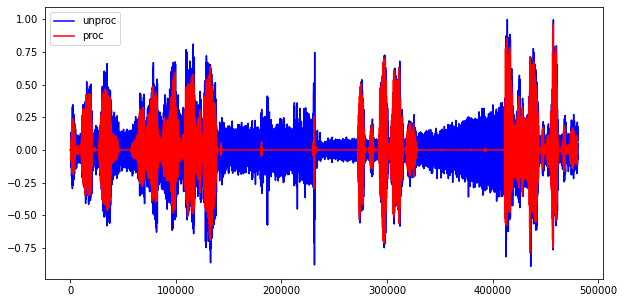

0.045520625829696654


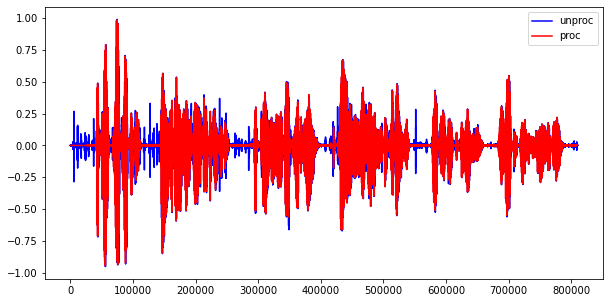

0.047128313451245754


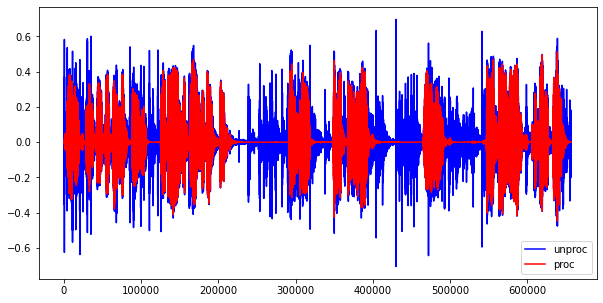

0.04659289592190793


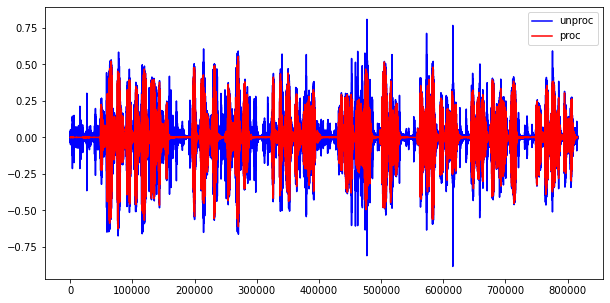

0.04720124081347254


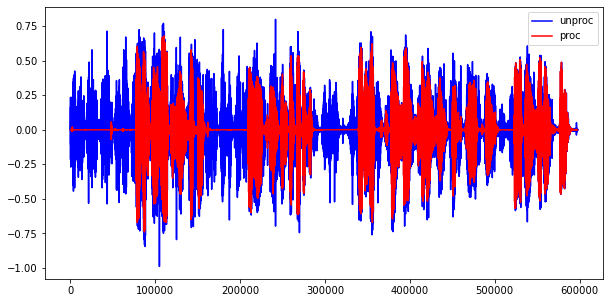

0.046097297952106146


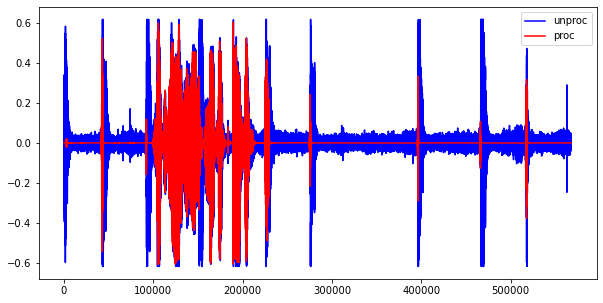

0.045787194255241484


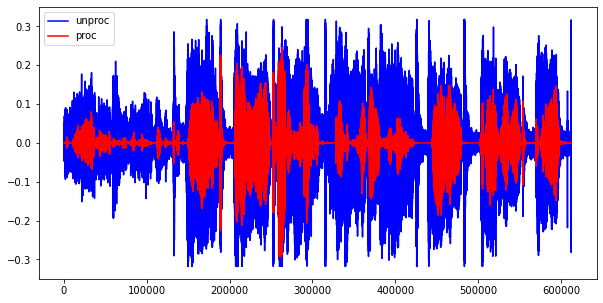

0.04617598159640443


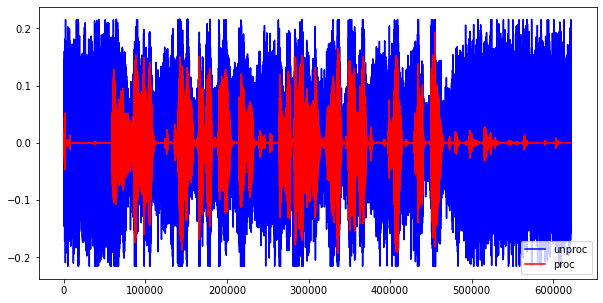

0.04861775401936535


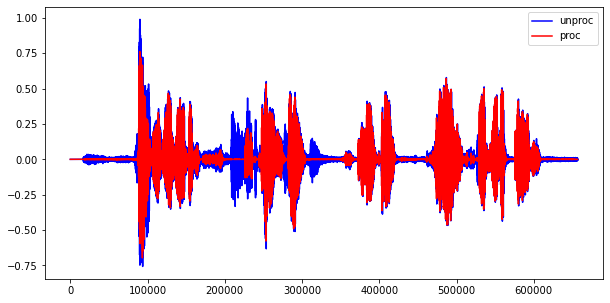

0.04642470212600139


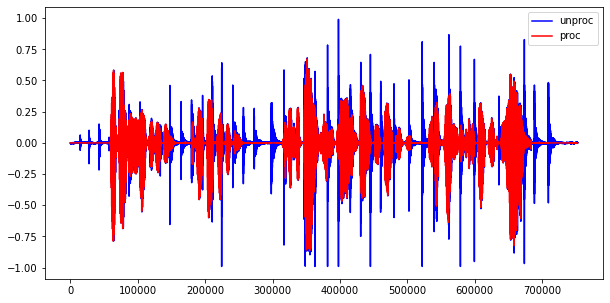

0.0467772059328022


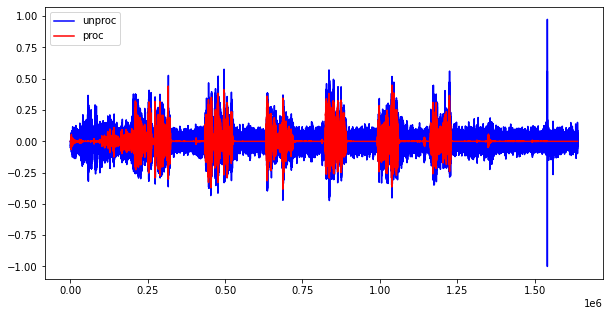

0.05100916810235494


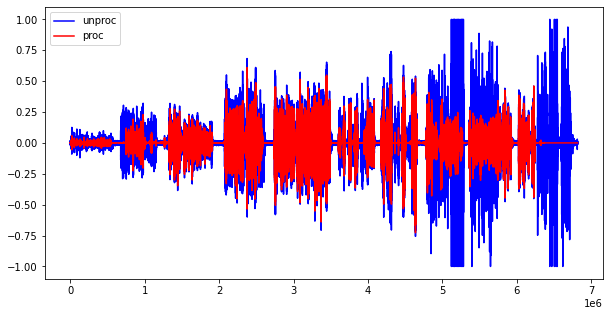

0.07583754069199321


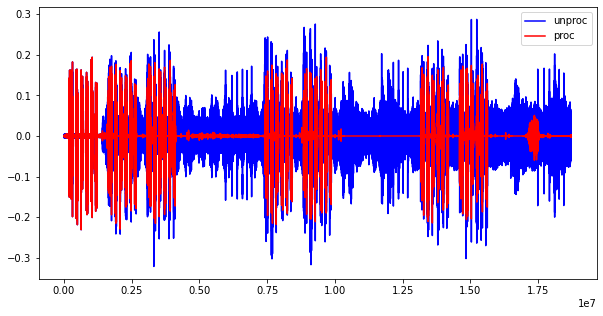

0.1397830371184227


In [50]:
import time
model.reset_states()  
buffer_frame=1
for file in audiofile:
    start = time.time()
    num_frame=process(file)
    end = time.time()
    print((end-start)/num_frame)

In [ ]:
def process_all(audiofile, process_path='/home/myhsueh/DeepFilterNet/wav/proc/dfn2/'):
    y, sr = librosa.load(audiofile, sr=None)
    
    Y = analysis_frame(y, normalize=True)
    
    buffer_frame = Y.shape[0]
    new_filename = os.path.basename(audiofile).replace('01','dfn'+str(buffer_frame))
    
    Y_erb = (np.real(Y)**2 + np.imag(Y)**2) @ ERB_Matrix
    Y_erb_norm = erb_norm(np.sqrt(Y_erb))
    Y_spec_norm = as_real(unit_norm(Y[:,:p.nb_df]))
                            
    buffer = Y
    buffer_erb = np.concatenate((np.zeros((2,32,1)),Y_erb_norm),axis=0)
    buffer_spec = np.concatenate((np.zeros((2,96,2)),Y_spec_norm),axis=0)
    
    Z = np.zeros_like(Y, dtype=complex)
                
    if p.mask_only:
        mask_out = model.predict(np.expand_dims(buffer_erb,0), verbose=0)
        buffer_real = np.concatenate((np.expand_dims(np.real(buffer),-1),np.expand_dims(np.imag(buffer),-1)),axis=-1)
        enhanced = mask_operations(buffer_real, mask_out, training=False) # mask gain
    else:
        buffer_feature = [np.expand_dims(np.expand_dims(buffer_erb,-1),0), np.expand_dims(buffer_spec,0)]
        mask_out, df_alpha, df_coeff = model.predict(buffer_feature, verbose=0)
        buffer_real = np.concatenate((np.expand_dims(np.real(buffer),-1),np.expand_dims(np.imag(buffer),-1)),axis=-1)
        buffer_spec_proc = mask_operations(buffer_real, mask_out, training=False) # mask gain
        enhanced = df_operations(buffer_spec_proc, df_coeff, df_alpha) # deep filter

    enhanced = np.squeeze(enhanced)
    Z = np.squeeze(enhanced[..., 0]+1j*enhanced[..., 1])
    
    model.reset_states()   
    
    z = synthesis_frame(Z, windowing=True, normalize=True)
    if not os.path.exists(process_path): os.makedirs(process_path)
    write(os.path.join(process_path,new_filename), z, 48000)
    
    plt.figure(figsize=(10,5))
    plt.plot(y, color = 'b')
    plt.plot(z, color = 'r')
    plt.legend(['unproc','proc'])
    plt.show()
    
    return Y.shape[0]

In [ ]:
# for file in audiofile:
#     start = time.time()
#     num_frame=process_all(file)
#     end = time.time()
#     print((end-start)/num_frame)